# [CptS 215 Data Analytics Systems and Algorithms](https://piazza.com/wsu/fall2017/cpts215/home)
[Washington State University](https://wsu.edu)

[Gina Sprint](http://eecs.wsu.edu/~gsprint/)
# L14-1 Case Study: Graph Mining

Learner objectives for this lesson:
* Interface with the Google Maps API
* Utilize a graph structure with real world data
    * US highways dataset
    * `networkx` `Graph` object
* Apply Dijkstra's algorithm to compute shortest paths


## Acknowledgments
Content used in this lesson is based upon information in the following sources:
* [Google Maps API](https://developers.google.com/maps/web-services/overview)
* [http://www2.lawrence.edu/fast/GREGGJ/CMSC150/101Graphs/highways.txt](http://www2.lawrence.edu/fast/GREGGJ/CMSC150/101Graphs/highways.txt)

## Case Study Overview
Before reading on in this lesson, read this article by Randal Olson: [*Computing the optimal road trip across the US*](http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/). 

Let's write a program that implements a solution to a similar, smaller problem. Randal mentions a Python script when he states "Thankfully, the Google Maps API makes this information freely available, so all it took was a short Python script to calculate the distance and time driven for all 2,450 routes between the 50 landmarks." In this case study, we are going to use the [Google Maps API](https://developers.google.com/maps/web-services/overview) to get real-time travel information. API stands for application programming interface. An API provides functions for programmers to use, without needing to know the details of the implementation. For example, Google Maps is a complex, well-tested program. We can use Google Maps via its API without knowing Google Map's details. This is also one of the beauties of functions. As long as we know:
1. The name of the function to call
1. What parameter(s) the functions expects
1. What the function returns

Then we can use Google Maps!

Note: some APIs require *authentication*, meaning an API key that uniquely identifies you and/or your program is used to gain access to the API. The first part of this case study we will use the Google Maps Distance Matrix API, which is unauthenticated. For the second part, we will use the Google Maps Embed API, for which we will have to generate and use an API key.

We will read in pairs of US cities that are connected by a major interstate highway from an input file. We will then construct a graph where each vertex is a US city and edges represent a highway connecting a pair of US cities. We will add attributes to the edges representing the distance in miles and the duration in seconds between the two cities the edge connects. We will get this information in real time via the Google Maps API. Lastly, we are going to prompt a user of program for an origin city and a destination city. Using Dijkstra's algorithm, we will find the shortest path between the two cities. We will also report how long it takes to drive between the two cities. To visualize the route, we will plot the route as a graph and use Google Maps Embed API to create a webpage with Google Maps embedded. Let's do this!

### Google Maps Distance Matrix API
Here is our code that queries the Google Maps Distance Matrix API and extracts the required information from the JSON response.

In [1]:
import urllib.request

def format_city_string(city_str):
    '''
    To prepare the city string for the query:
    1. remove comma
    2. replace spaces with +
    '''
    city_str = city_str.replace(",", "")
    city_str = city_str.replace(" ", "+")
    return city_str
  
def build_query(origin, dest):
    '''
    Builds the query string for the Google Distance Matrix API according to this website:
    https://developers.google.com/maps/documentation/distance-matrix/start
    '''
    query_base = "http://maps.googleapis.com/maps/api/distancematrix/json?origins="    
    query = query_base + origin
    query += "&destinations="
    query += dest
    query += "&mode=driving&sensor=false"
    return query
    
def extract_value(results_str, value):
    '''
    Extracts the value from the JSON response.
    '''
    index = results_str.find(value)
    results_str = results_str[index:]
    index = results_str.find("value")
    results_str = results_str[index:]
    index = results_str.find(":")
    results_str = results_str[index + 2:]
    index = results_str.find(r"\n")
    results_str = results_str[:index]
    dist = int(results_str)
    return dist
    
def get_distance_duration(city1, city2):
    '''
    Accepts 2 strings representing cities in the U.S.
    Returns a tuple of the integer distance in meters between city1 and city2
    and the integer number of seconds driving between city1 and city2
    '''
    city1 = format_city_string(city1)
    city2 = format_city_string(city2)
    
    query = build_query(city1, city2)

    web_obj = urllib.request.urlopen(query)
    # web_obj.read() returns an array of bytes, need to convert to a string
    results_str = str(web_obj.read())
    web_obj.close()
    
    dist = extract_value(results_str, "distance")
    duration = extract_value(results_str, "duration")
    return dist, duration

The `get_distance_duration(<city1 string>, <city2 string>)` returns a tuple of the distance (in meters) and driving duration (in seconds). Here is an example of how to call `get_distance_duration()`:

In [2]:
dist, dur = get_distance_duration("Seattle, WA", "Pullman, WA")
print("The distance between Seattle, WA and Pullman, WA is %d meters" %(dist))
print("The driving duration between Seattle, WA and Pullman, WA is %d seconds" %(dur))

The distance between Seattle, WA and Pullman, WA is 457989 meters
The driving duration between Seattle, WA and Pullman, WA is 16643 seconds


### Dataset
The road trip dataset we are going to use is a text file [highways.txt](https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/files/highways.txt) that I modified from its original source [http://www2.lawrence.edu/fast/GREGGJ/CMSC150/101Graphs/highways.txt](http://www2.lawrence.edu/fast/GREGGJ/CMSC150/101Graphs/highways.txt). According to the original dataset author, "[the data file] represents a significant portion of the interstate highway system." The text file is formatted such that on each line, there is an edge represented by two cities separated by a comma. These two cities are connected by a major highway.

Note: I performed the following modifications to the original dataset via the `remove_distance()` function:
* Replaced the underscores with spaces
* Separated city pairs by a comma
* Removed the distance integer. We will get this from Google Maps 

Manually:
* Removed cities Ontario, Birmingham, Florence, Cambridge, Seville, and Angola because without the state abbreviation after the city name, Google Maps was having a hard time figuring out which city was meant. For example, Ontario is meant to be Ontario, CA, but without the "CA" Ontario is ambiguous.

In [ ]:
def remove_distance():
    '''

    '''
    infile = open("highways_with_distances.txt", "r")
    outfile = open("highways.txt", "w")
    for line in infile.readlines():
        words = line.strip().split(" ")
        city1 = words[0]
        city1 = city1.replace("_", " ").lower()
        city2 = words[1]
        city2 = city2.replace("_", " ").lower()
        outfile.write("%s,%s\n" %(city1, city2))
        
    infile.close()
    outfile.close()

### Graph Representation
We are going to create a `networkx` `Graph` to represent the city-highway information. Each vertex in the graph will be a city (string key). For the edges in our graph, we are going to query the Google Maps API to find the distance (in miles) and driving time (in hours and minutes).

Note: While we could use our own implementation of a `Graph` class, to keep the code short, I am opting to use the `networkx` library's `Graph` object instead.

Note: I am pickling the `Graph` object for use if we are unable to connect to Google Maps for some reason (e.g. no Internet connection, exceeded API rate limit, Google Maps server is down, etc.). You can read more about Python pickling in the [Python `pickle` docs](https://docs.python.org/3/library/pickle.html) and in the [`networkx` `pickle` docs](https://networkx.github.io/documentation/networkx-1.9.1/reference/readwrite.gpickle.html).

In [3]:
import os
import networkx as nx

def meters_to_miles(meters):
    '''
    
    '''
    miles = meters * 0.000621371
    return miles    

def seconds_to_hours_mins(seconds):
    '''
    
    '''
    mins = seconds / 60
    hours = mins // 60
    mins = mins % 60
    return (hours, mins)

def read_in_highways(fname):
    '''

    '''
    G = nx.Graph()
    infile = open(fname, "r")
    for line in infile.readlines():
        words = line.strip().split(",")
        city1 = words[0]
        city2 = words[1]
        dist, dur = get_distance_duration(city1, city2)
        dist = meters_to_miles(dist)
        dist = round(dist, 1)
        
        if city1 not in G:
            G.add_node(city1)
        if city2 not in G:
            G.add_node(city2)
        G.add_edge(city1, city2, distance=dist, duration=dur)
    infile.close()
    
    return G

fname_base = "files\highways"
# adding support to save the graph by pickling
# this way we can still run the code without Google Maps connection
pickle_fname = fname_base + "_graph.pickle"
if os.path.isfile(pickle_fname):
    hwG = nx.read_gpickle(pickle_fname)
else:
    hwG = read_in_highways(fname_base + ".txt")
    nx.write_gpickle(hwG, pickle_fname)
print("Done")

Done


### Shortest Path
To compute the *shortest* route (in terms of distance) between the origin and the destination, we will use Dijkstra's algorithm. For a more local graph (i.e. one that connects vertices that are geographically close together), we may also be interested in computing the *fastest* route (in terms of time). We could easily do that using the `duration` edge attribute instead of the `distance` edge attribute. For our current vertices that are spread out all across the US and represent major highway connections, the shortest routes and the fastest routes are going to be the same. However, since we are getting real-time information from Google Maps, a crash on a interstate will cause Google Maps to return an alternative route that is faster but longer. To create a robust application, we would want to query Google Maps for alternative routes and add multiple edges with different weights to our graph.

### Graph Visualization using Networkx
We will visualize our graph using `networkx`'s spring layout.

seattle portland
173.0 9889
portland sacramento
579.9 32676
sacramento san francisco
87.9 5292
Total duration: 13 hours 17.62 minutes
Total distance: 840.80 miles


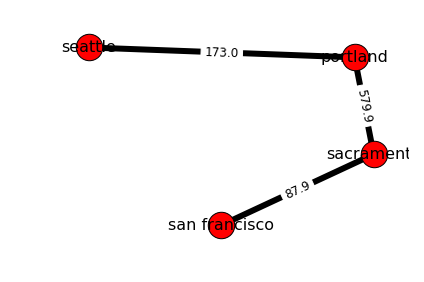

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def compute_shortest_path(nx_graph, origin, destination):
    '''
    
    '''
    path = nx.dijkstra_path(nx_graph, origin, destination, weight="distance")
    return path

def compute_path_distance_duration(G, path):
    '''
    
    '''
    duration = 0
    distance = 0
    for i in range(0, len(path) - 1, 1):
        city1 = path[i]
        city2 = path[i + 1]
        print(city1, city2)
        edge = G.get_edge_data(city1, city2)
        dist = edge["distance"]
        dur = edge["duration"]
        print(dist, dur)
        distance += dist
        duration += dur
        
    h_m = seconds_to_hours_mins(duration)
    return h_m, distance

def visualize_nx_graph(nx_graph):
    '''
    
    '''
    pos = nx.spring_layout(nx_graph)
    #pos = nx.circular_layout(nx_graph)
    nx.draw_networkx_nodes(nx_graph, pos, node_size=700)
    nx.draw_networkx_edges(nx_graph, pos, width=6)
    nx.draw_networkx_labels(nx_graph, pos, font_size=16, font_family='sans-serif')
    elabels = {edge:nx_graph[edge[0]][edge[1]]["distance"] for i, edge in enumerate(nx_graph.edges())}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=elabels, font_size=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
origin = "seattle"
destination = "san francisco"
path = compute_shortest_path(hwG, origin, destination)
path_duration, path_distance = compute_path_distance_duration(hwG, path) 
print("Total duration: %d hours %.2f minutes" %(path_duration[0], path_duration[1]))
print("Total distance: %.2f miles" %(path_distance))
sub_hwG = hwG.subgraph(path)
visualize_nx_graph(sub_hwG)

### Graph Visualization using Google Maps Embed API
Using the [Google Maps Embed API](https://developers.google.com/maps/documentation/embed/guide), we can create a webpage containing an embedded Google Map for a road trip path. For example, the webpage we are going to build for [highways.txt](https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/files/highways.txt) starting at Seattle and ending in San Francisco looks like the following:

<img src="https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/figures/seattle_to_sanfrancisco.png" width="500">

#### API Setup
To do this, you will need a free Google account and a free Google Maps API key:
1. Go to the [Google Maps Embed API page](https://developers.google.com/maps/documentation/embed/guide)
1. Scroll down to the "API Key" section and click the blue "Get a key" button 
1. Create a new project
1. Copy the API key. In your Python program, declare a variable called `api_key` to store your copied API key. 
    1. **Set `api_key` to an empty string before you submit your code to Blackboard.** The grader will use their own key to run your code.
    1. Why remove your API key? Read Google's ["Best practices for securing API keys"](https://support.google.com/googleapi/answer/6310037) page. The first bullet point reads: **"Do not embed API keys directly in code".** Storing your API key in a variable, `api_key` in your code is bad practice!! However, for this application it is "okay" because only you will have access to your key. If you are going to release your code to others follow Google's ["Best practices for securing API keys"](https://support.google.com/googleapi/answer/6310037). 
    

Next, read the [Google Maps Embed API documentation](https://developers.google.com/maps/documentation/embed/guide), specifically read:
1. Overview
2. Forming the URL
3. Directions mode (we will need to use the parameter `waypoints`)

#### Embed Code
Now, we are ready to write code! There are 3 coding tasks we need to do:
1. Build a string for the `waypoints` parameter according to the [Google Maps Embed API documentation](https://developers.google.com/maps/documentation/embed/guide). While iterating through each waypoint in the input file, use the provided `format_city_string()` function from the starter code and the string concatenation operator to build a string for the waypoints parameter.
1. Build an `<iframe>` according to the [Google Maps Embed API documentation](https://developers.google.com/maps/documentation/embed/guide). 
1. Write the `<iframe>` string to an HTML file

Now, programmatically open a web browser to the html file you just created. Python makes this really simple to do! To open a webpage, we can import the `webbrowser` module and pass in a string argument representing the webpage:

In [5]:
import webbrowser

def build_embed_iframe(origin, destination, waypoints):
    '''
    
    '''
    origin = format_city_string(origin)
    destination = format_city_string(destination)
    url = '<iframe width="1000" height="700" '
    # note this is not a valid key, you will need to insert your key here!!
    url += 'src="https://www.google.com/maps/embed/v1/directions?key=NOTAVALIDKEY'
    url += "&origin=" + origin
    url += "&destination=" + destination
    url += "&waypoints=" + waypoints
    url += "\" allowfullscreen></iframe>"

    return url
    
def extract_city_parameters(path):
    '''
    
    '''
    waypoints_str = ""
    origin = path[0]
    destination = path[-1]
    for i in range(1, len(path) - 1, 1):
        city = path[i]
        if waypoints_str == "":
            waypoints_str += format_city_string(city)
        else:
            waypoints_str += "|" + format_city_string(city)
    return origin, destination, waypoints_str

def launch_gmaps_in_browser(path, fname):
    '''
    
    '''
    origin, destination, waypoints = extract_city_parameters(path)
    url = build_embed_iframe(origin, destination, waypoints)

    temp = open(fname, "w")
    temp.write(url)    
    temp.close()
    webbrowser.open(fname)
    
launch_gmaps_in_browser(path, fname_base + ".html")

And the associated output file [highways.html](https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/files/highways.html) file. Opened with a web browser it looks like [highways.html](http://htmlpreview.github.com/?https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/files/highways.html).